# Major Project - ML-1/12B11

Predicting the costs of used cars given the data collected from various sources and distributed across various locations in India.

## Importing libraries


In [2]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## Reading dataset

In [3]:
dataset = pd.read_excel("Data_Train.xlsx")
dataset1 = pd.read_excel("Data_Test.xlsx")
dataset.head(5)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [5]:
 X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], 
                                                    dataset.iloc[:, -1], 
                                                    test_size = 0.4, 
                                                    random_state = 42)
Y_train, Y_test = train_test_split(dataset1.iloc[:, :-1],  
                                                    test_size = 0.4, 
                                                    random_state = 42)

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3611 entries, 4080 to 860
Data columns (total 12 columns):
Name                 3611 non-null object
Location             3611 non-null object
Year                 3611 non-null int64
Kilometers_Driven    3611 non-null int64
Fuel_Type            3611 non-null object
Transmission         3611 non-null object
Owner_Type           3611 non-null object
Mileage              3610 non-null object
Engine               3588 non-null object
Power                3588 non-null object
Seats                3585 non-null float64
New_Price            499 non-null object
dtypes: float64(1), int64(2), object(9)
memory usage: 366.7+ KB


# Exploratory Data Analysis

### Removing index column

The first column is the index for each data point and hence we can simply remove it.

In [7]:
X_train = X_train.iloc[:, :]
X_test = X_test.iloc[:, :]

### Name

In [8]:

    X_train["Name"].value_counts()

Mahindra XUV500 W8 2WD           30
Maruti Swift VDI                 28
Maruti Ritz VDi                  26
Maruti Swift Dzire VDI           23
Maruti Swift VDI BSIV            20
                                 ..
Nissan Sunny XV D                 1
Hyundai Santa Fe 2WD AT           1
Audi TT 40 TFSI                   1
Honda City 1.5 V AT Exclusive     1
Mahindra Logan Petrol 1.4 GLE     1
Name: Name, Length: 1490, dtype: int64

###### Inference -- As it appears, there are several cars in the dataset, some of them with a count higher than 1.
Sometimes the resale value of a car also depends on manufacturer of car and hence, we need to extract the manufacturer from this column and add it to the dataset.

In [9]:
make_train = X_train["Name"].str.split(" ", expand = True)
make_test = X_test["Name"].str.split(" ", expand = True)

In [10]:
X_train["Manufacturer"] = make_train[0]
X_test["Manufacturer"] = make_test[0]

##### Identify all unique values.

Text(0, 0.5, 'Count of cars')

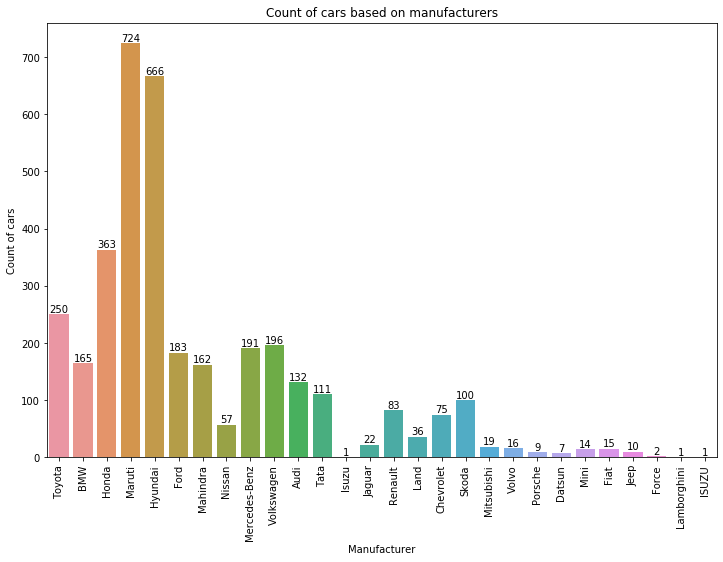

In [11]:
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Manufacturer', data = X_train)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Count of cars")

##### Inference -- Maximum cars in the dataset are by the manufacturer **Maruti** and there are no null values.

In [12]:
X_train.drop("Name", axis = 1, inplace = True)
X_test.drop("Name", axis = 1, inplace = True)

### Location

Location should not be a determinant for the price of a car, so removing it

In [144]:
X_train.drop("Location", axis = 1, inplace = True)
X_test.drop("Location", axis = 1, inplace = True)

### Year

Year has no significance on its own unless we try to extract how old a car is from this and see how its resale price may get affected.

In [145]:
curr_time = datetime.datetime.now()
X_train['Year'] = X_train['Year'].apply(lambda x : curr_time.year - x)
X_test['Year'] = X_test['Year'].apply(lambda x : curr_time.year - x)

##### Kilometers_Driven


In [146]:
X_train["Kilometers_Driven"]

4080     74000
818     108640
4091     26671
4368     20575
1697     63107
         ...  
3772     27000
5191      9000
5226    140000
5390     76414
860      98000
Name: Kilometers_Driven, Length: 3611, dtype: int64

##### Inference -- The data range is really varied and the high values might affect prediction, thus, it is really important that scaling be applied to this column for sure.

## Mileage

In [147]:
mileage_train = X_train["Mileage"].str.split(" ", expand = True)
mileage_test = X_test["Mileage"].str.split(" ", expand = True)

X_train["Mileage"] = pd.to_numeric(mileage_train[0], errors = 'coerce')
X_test["Mileage"] = pd.to_numeric(mileage_test[0], errors = 'coerce')

Checking for missing values.

In [148]:
print(sum(X_train["Mileage"].isnull()))
print(sum(X_test["Mileage"].isnull()))

1
1


There is one missing value in each. Replacing the missing value with the mean value of the column based on the training data.

In [149]:
X_train["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)
X_test["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)

### Engine, Power and Seats

Chopping off necessary part like cc, bhp,etc.
And replacing the missing values in with the mean.

In [150]:
cc_train = X_train["Engine"].str.split(" ", expand = True)
cc_test = X_test["Engine"].str.split(" ", expand = True)
X_train["Engine"] = pd.to_numeric(cc_train[0], errors = 'coerce')
X_test["Engine"] = pd.to_numeric(cc_test[0], errors = 'coerce')

bhp_train = X_train["Power"].str.split(" ", expand = True)
bhp_test = X_test["Power"].str.split(" ", expand = True)
X_train["Power"] = pd.to_numeric(bhp_train[0], errors = 'coerce')
X_test["Power"] = pd.to_numeric(bhp_test[0], errors = 'coerce')

In [151]:
X_train["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)
X_test["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)

X_train["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)
X_test["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)

X_train["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)
X_test["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)

### New Price

As most of the values are missing, droping this column altogether.

In [152]:
X_train.drop(["New_Price"], axis = 1, inplace = True)
X_test.drop(["New_Price"], axis = 1, inplace = True)

## Data Processing

Creating dummy columns for categorical columns before we begin training.

In [153]:
X_train = pd.get_dummies(X_train,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)

In [154]:
X_test = pd.get_dummies(X_test,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)

There's a chance that the dummy column creation would be different in test and train data, thus, filling in all missing columns with zeros.

In [155]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

Scaling the data--

In [156]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train = standardScaler.transform(X_train)
X_test = standardScaler.transform(X_test)

## Training and Predicting

Using Linear Regression model and a Random Forest model to train on the data and use it for future predictions.

In [157]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)
r2_score(y_test, y_pred)

0.7063834809676173

The Linear Regression model performed with a R2 score of **0.706**.

In [158]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.8934687647041325

The Random Forest model performed the best with a R2 score of **0.89**.